In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math 
from IPython.display import Image
%matplotlib inline

warnings.simplefilter('ignore')
plt.style.use('ggplot')

# Introdução

Neste trabalho foi-nos proposto, no contexto da cadeira de Introdução à Ciência de dados (CC40XX), lecionada na Faculdade de Ciências da Universidade do Porto, utilizar as ferramentas e técnicas analíticas para manipulação e tratamento de dados adquiridas ao longo do semestre num problema real e que exige um balanço de várias competências da parte dos elementos do nosso grupo de trabalho.


Começamos por identificar o problema que se nos deparou aquando da proposição do projeto. É-nos dito que são dados recolhidos do Real Hospital Português, no Brasil, devidamente anonimizados e éticamente aprovados. Também nos é dada a informação de que o principal objetivo é o de conseguir classificar a normalidade ou abnormalidade associada aos sintomas de crianças vítimas de uma doença cardiológica.


Assim, identificamos este como sendo o business problem que nos é proposto. A organização que disponibiliza os dados para análise pretende conseguir ajudar o maior número de pacientes possível assegurando o melhor e mais personalizado tratamento.


Em conluio com isto, o problema de análise de dados que nos compete solucionar é o de ser capaz de criar um, ou vários, modelos preditivos e assegurar a sua eficácia na classificação acertada da normalidade/abnormalidade sintomática.

# Raw Data

In [157]:
df = pd.read_excel('UCMF_2.xls')
df = df[:16700]

In [158]:
print(df.shape)
df.head(5)

(16700, 21)


,ID,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,...,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,1,5.0,51,19.0,11/05/06,30/03/06,0.12,GS,Normais,NaN,...,Não Calculado,Anormal,Normal,Sistólico,112,Palpitacao,NaN,M,6 - Suspeita de cardiopatia,6 - Palpitação/taquicardia/arritmia
1,2,3.5,50,14.0,25/05/05,19/05/05,0.02,GS,Normais,NaN,...,Não Calculado,Anormal,Normal,ausente,128,Dispneia,NaN,M,6 - Suspeita de cardiopatia,6 - Dispnéia
2,3,0.0,0,NaN,12/06/01,08/05/05,-4.05,SULA,Normais,NaN,...,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
3,4,8.1,65,19.0,15/10/09,21/04/09,0.5,NaN,Normais,NaN,...,Não Calculado,Anormal,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
4,5,39.5,142,20.0,23/01/09,24/10/99,9.6,Sulam,Normais,85.0,...,Normal,Anormal,Normal,ausente,90,NaN,NaN,M,5 - Parecer cardiológico,5 - Atividade física


Os dados foram-nos apresentados em formato Excel, organizados em 17872 linhas
e 21 colunas devidamente rotuladas. Numa fase inicial analisamos que tipo de informação nos era transmitida por cada coluna, categorizando as features.

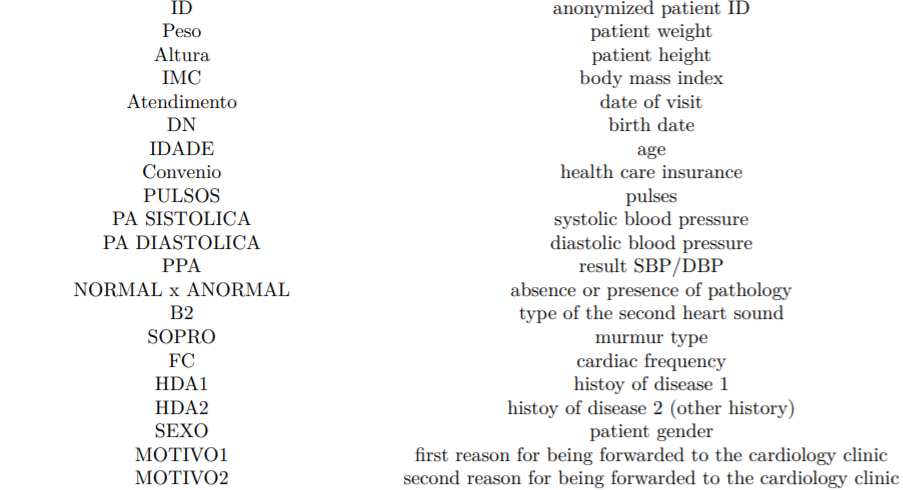

In [159]:
Image('tabela.png')

Após uma inspeção mais detalhada notamos que a maioria dos atributos rotulados com object têm uma mistura de vários tipos de dados. Por exemplo, associados ao atributo FC temos dados do tipo "int64" correspondentesa uma medição da frequência cardáica, e do tipo "string", correspondentes a um intervalo de valores, certamente devidos a imprecisão ou insegurança por parte do profissional de saúde na avaliação do paciente. 

Este será portanto um desafio para a fase de pré-processamento, tendo sido discutidas várias abordagens para a sua resolução como veremos na subsecção seguinte.

# Data Pre-processing

Nesta secção, apresentamos as alterações feitas aos dados em prol de facilitar
a sua análise e melhorar a eficácia da sua  classificação. 
Começamos por eliminar colunas irrelevantes para o problema de classificação em questão: visto que procuramos prever a variável "NORMAL X ANORMAL", que diz respeito a problemas de saúde físicos, podemos imediatamente eliminar as colunas "ID" e "CONVENIO", assumindo que nem a identificação nem o tipo de seguro de saúde do indivíduo afetam a sua saúde.

In [160]:
df = df.drop(columns = 'ID')
df = df.drop(columns = 'Convenio')

Para o que se segue, será útil representar o número de valores "NA" por coluna espalhados pela nossa base de dados , dado que estes valores terão de ser eliminados ou substituídos para procedermos à análise e previsão.

In [161]:
df.isna().sum()

Peso                  298
Altura                  0
IMC                  4402
Atendimento           925
DN                   1284
IDADE                1284
PULSOS               1130
PA SISTOLICA         7297
PA DIASTOLICA        7307
PPA                   217
NORMAL X ANORMAL     1101
B2                   1107
SOPRO                1099
FC                   1804
HDA 1                5066
HDA2                16084
SEXO                    0
MOTIVO1              1033
MOTIVO2              4468
dtype: int64

Podemos imediatamente eliminar a coluna correspondente a HDA2, pois está preenchida quase por completo por NAs.

In [162]:
df = df.drop(columns='HDA2')

# Idade

Na tabela acima, vemos que a idade tem 1284 valoes de "NA". Dado que estamos a tratar de dados de cardiologia pediátrica, podemos argumentar \textit{a priori} que a idade é um fator de elevada importância na previsão de anomalias cardíacas, visto que têm um grande papel no cálculo do IMC e nos percentis de pressão arterial que permitem consequentemente o diagnóstico de, por exemplo,  hipertensão arterial. Deste Com isto em vista, estaríamos a introduzir correlação indesejável se substituíssemos os valores de NA da idade por outros, sendo que é preferível eliminar estas entradas. Por sorte, vemos que ao eliminar estas entradas acabamos por eliminar também uma grande quantidade de NA's de outras colunas, indicando que isto é uma boa decisão

In [163]:
df1 = df.drop(index = df.loc[(df['IDADE'].isna()) | (df['IDADE'] == '#VALUE!') ].index)
(df.drop(columns = ['Altura','SEXO']).isna().sum() - df1.drop(columns = ['Altura','SEXO']).isna().sum())/df.drop(columns = ['Altura','SEXO']).isna().sum()

Peso                0.013423
IMC                 0.234666
Atendimento         0.950270
DN                  1.000000
IDADE               1.000000
PULSOS              0.659292
PA SISTOLICA        0.147184
PA DIASTOLICA       0.147119
PPA                 0.000000
NORMAL X ANORMAL    0.673933
B2                  0.670280
SOPRO               0.672429
FC                  0.438470
HDA 1               0.198184
MOTIVO1             0.848984
MOTIVO2             0.224485
dtype: float64

eliminando os NA's da idade, conseguimos também eliminar vários valores NA's de outras colunas, sendo de particular importância os 67% de NA's eliminados na variável "NORMAL X ANORMAL"

In [164]:
df.drop(index = df.loc[df['IDADE'].isna()].index, inplace = True)
df.drop(index = df.loc[df['IDADE'] == '#VALUE!'].index, inplace = True)

In [165]:
df.head(5)

,Peso,Altura,IMC,Atendimento,DN,IDADE,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,SEXO,MOTIVO1,MOTIVO2
0,5.0,51,19.0,11/05/06,30/03/06,0.12,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,112,Palpitacao,M,6 - Suspeita de cardiopatia,6 - Palpitação/taquicardia/arritmia
1,3.5,50,14.0,25/05/05,19/05/05,0.02,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,128,Dispneia,M,6 - Suspeita de cardiopatia,6 - Dispnéia
2,0.0,0,NaN,12/06/01,08/05/05,-4.05,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,M,2 - Check-up,NaN
3,8.1,65,19.0,15/10/09,21/04/09,0.5,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,92,Assintomático,M,5 - Parecer cardiológico,NaN
4,39.5,142,20.0,23/01/09,24/10/99,9.6,Normais,85.0,50.0,Normal,Anormal,Normal,ausente,90,NaN,M,5 - Parecer cardiológico,5 - Atividade física


Olhando para o df.head(5), reparamos numa particularidade -  temos valores de idade negativos! O valor da idade é obtido pela diferença entre a data de nacimento ('DN') e a data de atendimento ('Atendimento'), ou seja, temos uma coluna redundante (não adiciona mais informação). Porque é mais fácil trabalhar com dados no formato de números inteiros, vamos preservar a coluna correspondente à idade (depois de corrigirmos o 'bug' dos valores negativos) e a data de atendimento.

In [166]:
df['IDADE'] = df['IDADE'].abs()

Vamos representar os valores da coluna "IDADE" com um boxplot:

<AxesSubplot:>

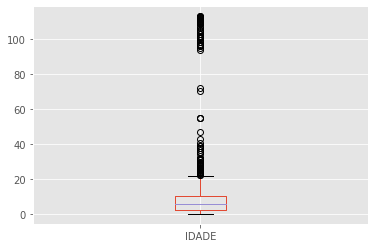

In [167]:
df['IDADE'].plot.box()

Identificamos uma gama de $\textit{outliers}$ que se estende desde os 20 aos 120 anos. para identificar o problema, vamos ver as colunas "Atendimento" e "DN" para idades acima dos 50 anos:

In [168]:
df.loc[df['IDADE'] > 50, ['Atendimento','DN']]

,Atendimento,DN
589,NaN,17/10/02
1213,NaN,07/01/08
1576,NaN,36973
1707,NaN,35493
2646,NaN,05/05/05
2789,NaN,19/05/08
2803,07/12/07,01/03/55
3366,NaN,25/10/00
3417,NaN,34704
3453,NaN,38666


In [169]:
print('Percentagem de valores de idade acima dos 20 anos: '+ str(len(df.loc[df['IDADE'] > 20])/len(df)*100)+'%') 

Percentagem de valores de idade acima dos 20 anos: 0.8293606739371776%


A partir da tabela acima, é fácil de identificar que o erro no cálculo da idade provém dos valores "NA" na coluna do "Atendimento". Como estamos, contudo, a tratar de dados de cardiologia pediátrica, a gama de idades estudada vai até aos 20 anos, de acordo com o site https://www.cdc.gov/growthcharts/clinical_charts.htm. Isto permite-nos eliminar os poucos $\textit{outliers}$ que existem nesta coluna sem grande consequência na análise de dados, visto que apenas 0.82% dos dados têm valores de idade acima dos 20 anos. 

<AxesSubplot:>

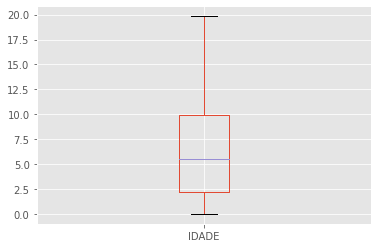

In [170]:
# import re
df.drop(index = df.loc[df['IDADE'] > 20].index,inplace = True)
df['IDADE'].plot.box()

Tendo a idade bem tratada, podemos eliminar as colunas "DN" e "Atendimento" por serem redundantes.

In [171]:
df.drop(columns = ['DN','Atendimento'], inplace = True)

# IMC/Peso/Altura

Existe mais um conjunto de colunas que possuem informação redundante, a tríade IMC, altura e peso, dado que o IMC é calculado a partir deste dois valores. Pode ser argumentado que é útil manter os três dados, porém, já que estamos a lidar com problemas cardiovasculares, podemos considerar que o IMC captura a informação de se uma pessoa está com o peso adequado à altura ou não. Por causa disso vamos eliminar as colunas correspondentes ao peso e à altura.

In [172]:
df.drop(columns = 'Peso', inplace=True)

Eliminamos todas as colunas redundantes (data de nascimento) e inúteis (ID). As colunas restantes são importantes para a análise que queremos fazer. Temos, porém de tratar dos valores NAs que temos nas colunas restantes.


# Sexo

In [173]:
df['SEXO'].unique()

array(['M', 'F', 'Indeterminado'], dtype=object)

Como podemos ver, temos rótulos de sexo redundantes ('Masculino' e 'M' por exemplo). Logo, temos de definir um standard (que neste caso será 'M' e 'F').

In [174]:
df['SEXO'].loc[df['SEXO'] == 'Masculino'] = 'M'
df['SEXO'].loc[df['SEXO'] == 'masculino'] = 'M'
df['SEXO'].loc[df['SEXO'] == 'Feminino'] = 'F'

# PA Sistolica

O atributo pressão arterial sistólica apresentava, na tabela original, 7297 valores NA. Fazendo o histograma dos valores que estão atribuídos obtemos a figura seguinte.

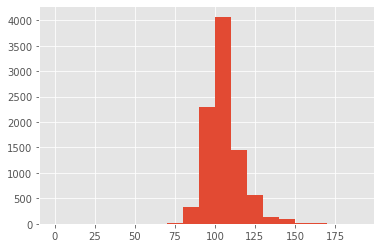

In [175]:
plt.hist(df['PA SISTOLICA'][df['PA SISTOLICA'].notna()], bins = np.arange(0,200,10))
plt.show()

Notamos uma clara distribuição realtivamente bem centrada em torno de um valor médio próximo de 100, por isso achamos que a melhor forma de lidar com os valores não atribuídos era substituí-los pelo valor médio.


In [176]:
df.loc[df['PA SISTOLICA'].isna(),'PA SISTOLICA'] = df['PA SISTOLICA'].mean()

# PA Diastolica

Podemos fazer uma análise muito similar para a pressão arterial diastólica e vemos mais uma vez que a distribuição dos valores atribuídos se encontra centrada em torno de um valor médio bem definido. Procedemos, então, mais uma vez à imputação deste valor em substituição dos NA.

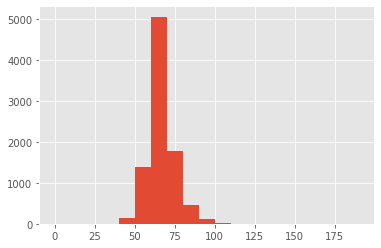

In [177]:
plt.hist(df['PA DIASTOLICA'][df['PA DIASTOLICA'].notna()], bins = np.arange(0,200,10))
plt.show()

In [178]:
mediana_PA_D = np.median(df['PA DIASTOLICA'][df['PA DIASTOLICA'].notna()])

In [179]:
df.loc[df['PA DIASTOLICA'].isna(),'PA DIASTOLICA'] = df['PA DIASTOLICA'].mean()

# Normal x Anormal

Como vimos acima, existem 396 valores não-atribuídos para este atributo.Como esta é a variável que nós vamos tentar prever e o número de valores inexistentes é relativamente baixo não vamos danificar os nossos dados com linhas que não estão rotulados com respeito a este atributo.


In [180]:
df['NORMAL X ANORMAL'].unique()

array(['Anormal', 'Normal', nan, 'anormal'], dtype=object)

In [181]:
df = df[df['NORMAL X ANORMAL'].notna()]
df.loc[df['NORMAL X ANORMAL'] == 'anormal', 'NORMAL X ANORMAL'] = 'Anormal'
df.loc[df['NORMAL X ANORMAL'] == 'Normais', 'NORMAL X ANORMAL'] = 'Normal'


# IMC

Para colmatar os NAs presentes na coluna correspondente ao IMC, vamos utilizar a média correspondenete para cada género, ou seja, se o paciente for homem o seu IMC vai corresponder à media do IMC masculino. Para começar vamos eliminar os pacientes sem sexo identificado (4).

In [182]:
df = df[df['SEXO'].notna()]

mediaM = df.loc[(df['SEXO'] == 'M') & (df['IMC'].notna()),'IMC'].mean()
mediaF = df.loc[(df['SEXO'] == 'F') & (df['IMC'].notna()),'IMC'].mean()


df.loc[(df['SEXO'] == 'M') & (df['IMC'].isna()),'IMC'] = mediaM
df.loc[(df['SEXO'] == 'F') & (df['IMC'].isna()),'IMC'] = mediaF


## PPA

In [183]:
df['PPA'].unique()

array(['Não Calculado', 'Normal', 'Pre-Hipertensão PAS', 'HAS-2 PAS',
       'Pre-Hipertensão PAD', nan, 'HAS-1 PAS', 'HAS-2 PAD', 'HAS-1 PAD'],
      dtype=object)

De acordo com os sites https://secad.artmed.com.br/blog/medicina/hipertensao-infantil/ e https://drauziovarella.uol.com.br/pediatria/hipertensao-arterial-infantil/, se o indivíduo se encontra entre os percentis 90% e 95% o diagnóstico é pré-hipertensão, se for entre os 95 e 99 é hipertensão estágio 1 e para cima de 99 é hipertensão estágio 2. Pelas tabelas fornecidas como suplementar, vemos que as curvas dos percentis dependem da idade, da altura  e do sexo. Como não encontramos nenhuma dataframe disponível com estes dados, convertemos o pdf fornecido para csv. Depois de alguma (bastante) edição no vim, conseguimos criar duas dataframes destes valores - uma para rapazes e outra para raparigas - bem como 2 dataframes que determinam os percentis das alturas baseadas na idade do indivíduo, obtidas do site https://www.cdc.gov/growthcharts/clinical_charts.htm. 

In [184]:
boys_bp = pd.read_csv('bp_boys.csv', delimiter = ' ')
girls_bp = pd.read_csv('bp_girls.csv', delimiter = ' ')
boys_bp['I'] = boys_bp['I']*12
girls_bp['I'] = girls_bp['I']*12
boys_age1 = pd.read_csv('boys_age.csv', delimiter = ';')
girls_age1 = pd.read_csv('girls_age.csv', delimiter = ';')
boys_age2 = pd.read_csv('boys_age1.csv', delimiter = ';')
girls_age2 = pd.read_csv('girls_age1.csv', delimiter = ';')
boys_age = boys_age1.append(boys_age2,ignore_index = True)
girls_age = girls_age1.append(girls_age2,ignore_index = True)
boys_age.drop(columns = ['3','97'],inplace = True)
girls_age.drop(columns = ['3','97'],inplace = True)


FileNotFoundError: [Errno 2] No such file or directory: 'bp_boys.csv'

Precisamos primeiro de encontrar o percentil da altura. Para cada idade, pesquisamos a sua altura na tabela e obtemos o percentil correspondente. 

In [185]:
df.drop(index = df.loc[df['Altura'] == 0].index,inplace = True)
df.drop(index = df.loc[df['IDADE'] > 18.].index,inplace = True)

In [186]:
df_boys = df.loc[df['SEXO'] == 'M']
df_boys['IDADE'] = df_boys['IDADE']*12
df_boys['ALTURA PER'] = 0
for i in range(len(df_boys)):
    linha = df_boys.iloc[i]
    serie_altura = boys_age.loc[boys_age['Age'] <= linha['IDADE']].iloc[-1].iloc[1:]
    PER_SER = serie_altura.loc[serie_altura <= linha['Altura']]
    if len(PER_SER) == 0:
        PER = 1
    else:
        PER = PER_SER.index[-1]
    df_boys['ALTURA PER'].iloc[i] = PER

NameError: name 'boys_age' is not defined

In [187]:
df_girls = df.loc[df['SEXO'] == 'F']
df_girls['IDADE'] = df_girls['IDADE']*12
df_girls['ALTURA PER'] = 0
for i in range(len(df_girls)):
    linha = df_girls.iloc[i]
    serie_altura = girls_age.loc[girls_age['Age'] <= linha['IDADE']].iloc[-1].iloc[1:]
    PER_SER = serie_altura.loc[serie_altura <= linha['Altura']]
    if len(PER_SER) == 0:
        PER = 1
    else:
        PER = PER_SER.index[-1]
    df_girls['ALTURA PER'].iloc[i] = PER

NameError: name 'girls_age' is not defined

In [188]:
df_boys['ALTURA PER'].unique()

array([0], dtype=int64)

Agora precisamos de encontrar, para cada idade e cada percentil de altura, o percentil onde se enquadram a pressão sistólica e diastólica.

In [189]:
boys_bp_s = boys_bp[['I','PE','5','10','25','50','75','90','95']]
boys_bp_d = boys_bp[['I','PE','5.1','10.1','25.1','50.1','75.1','90.1','95.1']]
boys_bp_d.columns = ['I','PE','5','10','25','50','75','90','95']

girls_bp_s = girls_bp[['I','PE','5','10','25','50','75','90','95']]
girls_bp_d = girls_bp[['I','PE','5.1','10.1','25.1','50.1','75.1','90.1','95.1']]
girls_bp_d.columns = ['I','PE','5','10','25','50','75','90','95']

NameError: name 'boys_bp' is not defined

In [190]:
df_boys.loc[df_boys['ALTURA PER'] == 1,'ALTURA PER'] = 5
df_girls.loc[df_girls['ALTURA PER'] == 1,'ALTURA PER'] = 5

In [191]:
df_boys['PAS PER'] = 0
for i in range(len(df_boys)):
    linha = df_boys.iloc[i]
    A_P, idade  = str(linha['ALTURA PER']), linha['IDADE']
    if idade < 12:
        PA_series = boys_bp_s.loc[boys_bp_s['I'] == 12]
    else: 
        PA_series = boys_bp_s.loc[boys_bp_s['I'] <= idade][-4:] #### verificar se dá direito 
    fernando = PA_series.loc[PA_series[A_P]<=linha['PA SISTOLICA'],'PE']
    if len(fernando) == 0:
        PA_PER = 1
    else:
        PA_PER = PA_series.loc[PA_series[A_P]<=linha['PA SISTOLICA'],'PE'].iloc[-1]
    df_boys['PAS PER'].iloc[i] = PA_PER
    
    
df_boys

NameError: name 'boys_bp_s' is not defined

In [192]:
df_boys['PAD PER'] = 0
for i in range(len(df_boys)):
    linha = df_boys.iloc[i]
    A_P, idade  = str(linha['ALTURA PER']), linha['IDADE']
    if idade < 12:
        PA_series = boys_bp_d.loc[boys_bp_d['I'] == 12]
    else: 
        PA_series = boys_bp_d.loc[boys_bp_d['I'] <= idade][-4:] #### verificar se dá direito 
    fernando = PA_series.loc[PA_series[A_P]<=linha['PA DIASTOLICA'],'PE']
    if len(fernando) == 0:
        PA_PER = 1
    else:
        PA_PER = PA_series.loc[PA_series[A_P]<=linha['PA DIASTOLICA'],'PE'].iloc[-1]
    df_boys['PAD PER'].iloc[i] = PA_PER

NameError: name 'boys_bp_d' is not defined

In [193]:
df['PPA'].unique()

array(['Não Calculado', 'Normal', 'Pre-Hipertensão PAS', 'HAS-2 PAS',
       'Pre-Hipertensão PAD', nan, 'HAS-1 PAS', 'HAS-2 PAD', 'HAS-1 PAD'],
      dtype=object)

In [194]:
df_boys['PPA CALC'] = ''
df_boys.loc[(df_boys['PAS PER'] < 90)&(df_boys['PAD PER']<90),'PPA CALC'] = 'Normal'
df_boys.loc[df_boys['PAS PER'] == 90,'PPA CALC'] = 'Pre-Hipertensão PAS'
df_boys.loc[df_boys['PAD PER'] == 90,'PPA CALC'] = 'Pre-Hipertensão PAD'
df_boys.loc[df_boys['PAD PER'] == 95,'PPA CALC'] = 'HAS-1 PAD'
df_boys.loc[df_boys['PAS PER'] == 95,'PPA CALC'] = 'HAS-1 PAS'
df_boys.loc[df_boys['PAD PER'] == 99,'PPA CALC'] = 'HAS-2 PAD'
df_boys.loc[df_boys['PAS PER'] == 99,'PPA CALC'] = 'HAS-2 PAS'
df_boys1 = df_boys.drop(index = df_boys.loc[((df_boys['PPA'] == 'Não Calculado') | df_boys['PPA'].isna())|(df_boys['IDADE']<12)].index)
print(len(df_boys1.loc[df_boys1['PPA'] == df_boys1['PPA CALC']])/len(df_boys1))
print(len(df_boys1.loc[df_boys1['PPA'] == 'Normal'])/len(df_boys1))

0.8667982239763197
0.8667982239763197


In [195]:
df_boys1.loc[df_boys1['PPA'] != df_boys1['PPA CALC']]

,Altura,IMC,IDADE,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,SEXO,MOTIVO1,MOTIVO2,ALTURA PER,PAS PER,PAD PER,PPA CALC
23,133,16.0,101.16,Normais,140.0,100.0,HAS-2 PAS,Anormal,Normal,sistólico,100,Outro,M,6 - Suspeita de cardiopatia,6 - HAS/dislipidemia/obesidade,0,0,0,Normal
26,143,26.0,119.4,Normais,120.0,80.0,Pre-Hipertensão PAS,Normal,Normal,ausente,90,NaN,M,6 - Suspeita de cardiopatia,6 - HAS/dislipidemia/obesidade,0,0,0,Normal
30,109,17.0,63.12,Normais,100.0,70.0,Pre-Hipertensão PAD,Normal,Normal,Sistólico,88,NaN,M,6 - Suspeita de cardiopatia,6 - Sopro,0,0,0,Normal
47,112,21.0,46.56,Normais,120.0,70.0,HAS-2 PAS,Anormal,Normal,Sistólico,80,Assintomático,M,6 - Suspeita de cardiopatia,6 - Sopro,0,0,0,Normal
219,145,29.0,124.56,Normais,130.0,80.0,HAS-2 PAS,Anormal,Normal,sistólico,88,Assintomático,M,5 - Parecer cardiológico,5 - Atividade física,0,0,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16638,165,25.0,178.56,Normais,130.0,70.0,HAS-1 PAS,Normal,Normal,ausente,NaN,NaN,M,5 - Parecer cardiológico,5 - Cirurgia,0,0,0,Normal
16640,107,15.0,57.12,Normais,100.0,70.0,Pre-Hipertensão PAD,Anormal,Normal,Sistólico,88,Assintomático,M,5 - Parecer cardiológico,5 - Atividade física,0,0,0,Normal
16641,151,26.0,163.08,Normais,160.0,80.0,HAS-2 PAS,Anormal,Normal,Sistólico,120,Assintomático,M,5 - Parecer cardiológico,5 - Atividade física,0,0,0,Normal
16686,160,29.0,188.52,Normais,130.0,60.0,HAS-1 PAS,Anormal,Normal,ausente,76,Outro,M,6 - Suspeita de cardiopatia,6 - HAS/dislipidemia/obesidade,0,0,0,Normal


Se pegarmos neste ultimo exemplo (idade 33.72 meses, altura 89 centimetros, PAS 90 e PAD 60) e formos ver manualmente nas tabelas fornecidas, os percentis identificados pelo programa estão corretos e mesmo assim o resultado difere do original, o que pode ser uma indicação de que as tabelas de percentis sejam diferentes.

In [196]:
np.sort(df['IDADE'].unique())

array([0, 0.01, 0.02, ..., 17.95, 17.97, 17.99], dtype=object)

In [197]:
df_medio = df[['SEXO','Altura','IDADE','PA SISTOLICA','PA DIASTOLICA','PPA']]
df_medio.drop(index = df_medio.loc[(df_medio['IDADE'] < 1) | (df_medio['SEXO'] == 'Indeterminado')].index,inplace = True)
df_calc = df_medio.drop(columns = 'PPA')
df_calc['IDADE'] = df_calc['IDADE']*12
df_calc.columns = ['sex','height','agemons','sbp','dbp']
df_calc['id'] = df_calc.index
df_calc
df_calc.to_csv('calc_ppa.csv',index = False)
df_calc.head(4).to_csv('calc_ppa_copia.csv',index = False)

In [198]:
df_final = pd.read_csv('out_calc_ppa.csv')
df_final.columns = ['id', 'sex', 'height', 'agemons', 'sbp', 'dbp', 'outlier', 'ht1', 'ht2','syspct', 'diapct', 'fxsys90', 'fxsys95', 'fxdia90', 'fxdia95','PPA CALC']
df_final['PPA CALC'].unique()

FileNotFoundError: [Errno 2] No such file or directory: 'out_calc_ppa.csv'

## PPA

In [199]:
df.drop(index=df.loc[(df['PPA']=='Não Calculado') | (df['PPA'].isna())].index, inplace=True)

## Pulsos

In [200]:
df['PULSOS'].unique()

array(['Normais', nan, 'Outro', 'Femorais diminuidos', 'Amplos',
       'Diminuídos '], dtype=object)

Temos mais uma vez rótulos redundantes, logo vamos aplicar um tratamento similar ao utilizado no Sexo. Vamos substituir os nan por Normais.

In [201]:
df.loc[df['PULSOS'] == 'NORMAIS', 'PULSOS'] = 'Normais'
df.loc[df['PULSOS'] == 'AMPLOS', 'PULSOS'] = 'Amplos'
df.loc[df['PULSOS'].isna(), 'PULSOS'] = 'Normais'

## Sopro

In [202]:
df['SOPRO'].unique()

array(['ausente', 'sistólico', 'Sistólico', 'Contínuo', 'diastólico',
       'contínuo'], dtype=object)

Podemos valores que tipo de rótulos estão associados a este atributo. Vemos que existem casos de rótulos que tencionam ser o mesmo porém o programa interpretaria como diferentes pois diferem ortograficamente no nosso \textit{dataset}, como é o caso de "contínuo" e "Contínuo". Manualmente, podemos então solucionar esta inconveniência concordando numa grafia e alterando as que divergem desta. Para o caso dos valores NA que são 1167 imputaremos todos com o rótulo "ausente" 

In [203]:
df.loc[df['SOPRO'] == 'sistólico','SOPRO'] = 'Sistólico'
df.loc[df['SOPRO'] == 'contínuo','SOPRO'] = 'Contínuo'
df.loc[df['SOPRO'].isna(),'SOPRO'] = 'ausente'

## FC

In [204]:
from scipy import stats
coiso = []
for i in df['FC']:
    if type(i) == str:
        coiso.append(i)

def string_converter(string):
    if type(string) == str:
        nums = np.array([char for char in string])
        hif = np.where(nums == '-')
        if not not hif[0]:
            pal1 = ''.join(nums[:hif[0][0]])
            pal2 = ''.join(nums[hif[0][0]+1:])
        else:
            hif = np.where(nums == 'a')
            pal1 = ''.join(nums[:hif[0][0]-1])
            pal2 = ''.join(nums[hif[0][0]+2:])
        num1 = int(pal1)
        num2 = int(pal2)
        return .5*(num1 + num2)
    else:
        return string

df['FC'] = df['FC'].apply(string_converter)

(array([2.430e+02, 0.000e+00, 3.000e+01, 1.250e+03, 4.472e+03, 9.110e+02,
        6.600e+01, 1.100e+01, 1.000e+00, 2.000e+00]),
 array([  0.96550243,  20.06895219,  39.17240195,  58.2758517 ,
         77.37930146,  96.48275122, 115.58620097, 134.68965073,
        153.79310049, 172.89655024, 192.        ]),
 <BarContainer object of 10 artists>)

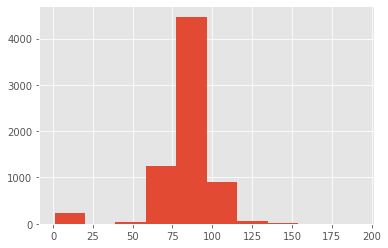

In [205]:
dropar_outl = (df['FC'].dropna())[np.abs(stats.zscore(df['FC'].dropna())) > 3].index
df.drop(dropar_outl,axis=0,inplace = True)
df['FC'] = df['FC'].fillna(np.mean(df['FC'].notna()))
plt.hist(df['FC'])

Como foi referido anteriormente, a coluna FC tem uma mistura de valores inteiros e intervalos de valores que são guardados como $\textit{string}$. Para colmatar isto, escrevemos uma rotina que lê o primeiro e o último valor do intervalo e substitui esse dado pelo valor médio do intervalo de valores. Para além disso, este conjunto de dados também tinha outliers que forma eliminados pelo critério de z-score como foi feito para outros atributos que apresentavam peculiaridades similares.

## HDA1

In [206]:
df['HDA 1'].unique()    #Não há problemas de duplicação de rótulos

array([nan, 'Assintomático', 'Desmaio/tontura', 'Dor precordial', 'Outro',
       'Palpitacao', 'Dispneia', 'Ganho de peso', 'Cianose'], dtype=object)

In [207]:
df['HDA 1'][df['HDA 1'].isna()] = ['Outro'] * np.sum(df['HDA 1'].isna())

Verificamos que não existem redundâncias óbvias nos rótulos deste atributo. Assim que asseguramos que estas não existiam, verificamos que existiam 3962 NA's neste atributo. Como já existia um rótulo de "Outro" decidimos que seria seguro considerar os valores não atribuídos como sendo "Outro" a fim de não introduzir enviesamentos estatíticos pela eliminação destes valores e por causa da dificuldade de prever esta caraterística.


## Motivo 1

In [208]:
df['MOTIVO1'].unique() #Não há problema de duplicação de rótulos

array(['5 - Parecer cardiológico', '2 - Check-up',
       '6 - Suspeita de cardiopatia', '1 - Cardiopatia já estabelecida',
       '7 - Outro', nan], dtype=object)

In [209]:
df['MOTIVO1'][df['MOTIVO1'].isna()] = ['7 - Outro'] * np.sum(df['MOTIVO1'].isna())

Para o Motivo 1 empregamos a mesma estratégia que utilizamos para o HDA1, ou seja, averiguamos redundâncias e substituímos os valores não atribuídos pelo rótulo já existente "7 - Outro" pelas razões supracitadas.


## Motivo 2

In [210]:
df['MOTIVO2'].unique() #Não há problema de duplicação de rótulos


array(['5 - Atividade física', nan, '5 - Cirurgia',
       '6 - Palpitação/taquicardia/arritmia',
       '6 - HAS/dislipidemia/obesidade', '6 - Sopro', 'Outro',
       '6 - Dor precordial', '6 - Dispnéia', '1 - Cardiopatia congenica',
       '6 - Cansaço', '1 - Cardiopatia adquirida',
       '6 - Cardiopatia na familia', '6 - Cianose',
       '6 - Cianose e dispnéia', '5 - Uso de cisaprida'], dtype=object)

In [211]:
df['MOTIVO2'][df['MOTIVO2'].isna()] = ['Outro'] * np.sum(df['MOTIVO2'].isna())

Mais uma vez fizemos o mesmo procedimento para este atributo.


## B2

In [212]:
df['B2'].unique()

array(['Normal', 'Desdob fixo', 'Outro', 'Hiperfonética', 'Única', nan],
      dtype=object)

In [213]:
df['B2'][df['B2'].isna()] = ['Outro'] * np.sum(df['B2'].isna())

# Criação do dataset de previsão

In [214]:
df.isna().sum()

Altura              0
IMC                 0
IDADE               0
PULSOS              0
PA SISTOLICA        0
PA DIASTOLICA       0
PPA                 0
NORMAL X ANORMAL    0
B2                  0
SOPRO               0
FC                  0
HDA 1               0
SEXO                0
MOTIVO1             0
MOTIVO2             0
dtype: int64

Neste momento, temos o nosso dataset livre de NAs e sem duplicação de rótulos. Temos agora em frente a difícil tarefa de procurar os padrões neste problema com uma elevada dimensionalidade.

Agora, vamos dividir o nosso dataset. Criaremos o df2 - dataset que vai ser usado nos modelos preditivos. Este dataset vai ser devidamente normalizado e as variáveis categóricas vão ser substituídas por variáveis discretas numéricas, de modo a ser mais fácil serem processadas pelos algoritmos de machine learning.

Por outro lado, vamos continuar a utilizar o dataset original para análise das correlações entre variáveis, clustering, etc

In [215]:
df2 = df

df2.loc[df2['SEXO'] == 'M', 'SEXO'] = 0
df2.loc[df2['SEXO'] == 'F', 'SEXO'] = 1

df2.loc[df2['NORMAL X ANORMAL'] == 'Normal', 'NORMAL X ANORMAL'] = 0
df2.loc[df2['NORMAL X ANORMAL'] == 'Anormal', 'NORMAL X ANORMAL'] = 1


#O código seguinte serva para tornar as variaveis categóricas numéricas. O código poderia ser mais elegante.


j=0

for i in (df2['PULSOS'].unique()):
    df2.loc[df2['PULSOS'] == i, 'PULSOS'] = j
    j+=1
    
    
j=0

for i in (df2['B2'].unique()):
    df2.loc[df2['B2'] == i, 'B2'] = j
    j+=1
    
j=0

for i in (df2['SOPRO'].unique()):
    df2.loc[df2['SOPRO'] == i, 'SOPRO'] = j
    j+=1
    

j=0

for i in (df2['HDA 1'].unique()):
    df2.loc[df2['HDA 1'] == i, 'HDA 1'] = j
    j+=1
    
j=0

for i in (df2['MOTIVO1'].unique()):
    df2.loc[df2['MOTIVO1'] == i, 'MOTIVO1'] = j
    j+=1
    
j=0

for i in (df2['MOTIVO2'].unique()):
    df2.loc[df2['MOTIVO2'] == i, 'MOTIVO2'] = j
    j+=1
    
j=0

for i in (df2['PPA'].unique()):
    df2.loc[df2['PPA'] == i, 'PPA'] = j
    j+=1
    
    
#Para normalizar as colunas    
df2=(df2-df2.min())/(df2.max()-df2.min())

In [216]:
df2.head(5)

,Altura,IMC,IDADE,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,SEXO,MOTIVO1,MOTIVO2
4,0.600,0.40,0.505329,0,0.416667,0.385965,0,1,0,0,0.466065,0,0,0,0
5,0.360,0.42,0.17931,0,0.500000,0.473684,0,1,0.25,0,0.518412,0.142857,0,0.25,0.0714286
7,0.400,0.40,0.272727,0,0.555556,0.517544,0.166667,1,0,0,0.413718,0.142857,1,0,0.142857
10,0.440,0.32,0.294671,0,0.500000,0.517544,0,1,0,0.333333,0.455596,0.142857,0,0,0.142857
16,0.176,0.26,0.0739812,0,0.444444,0.473684,0,0,0,0,0.492238,0.142857,1,0,0.142857


# Data Transformation

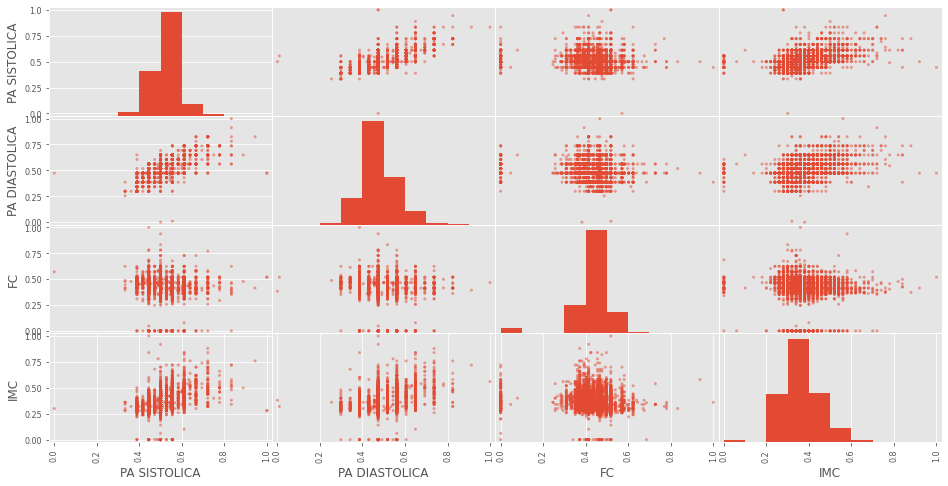

In [217]:
colunas_num = ['IDADE', 'PA SISTOLICA','PA DIASTOLICA','FC','IMC']
pd.plotting.scatter_matrix(df2[colunas_num],figsize=(16,8));

A fim de ter uma análise preliminar dos dados já tratados vamos ver a como é que as quantidades numéricas se relacionam entre elas através da função scatter_matrix do pandas. Podemos ver a clara correlação linear que existe a pressão arterial sistólica e a pressão arterial diastólica que era, desde já, um resultado esperado e que atesta a fidedignidade dos nossos dados. Entre o IMC e tanto a PA diastólica como diastólica não vemos uma clara correlação. Vemos sim, um $\textit{clustering}$ dos dados visto que as 3 distribuições são relativamente bem centradas como podemos ver nos histogramas na diagonal da matriz. Podemos argumentar a favor de uma ligeira correlação linear positiva entre IMC e as PA, que estaria de acordo com a nossa intuição, porém não evidente nos gráficos. 

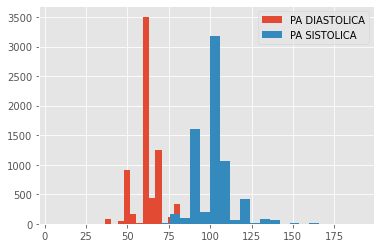

In [218]:
df['PA DIASTOLICA'].hist(bins = 30, label = 'PA DIASTOLICA')
df['PA SISTOLICA'].hist(bins = 30, label= 'PA SISTOLICA')
plt.legend()

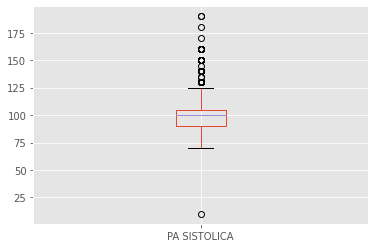

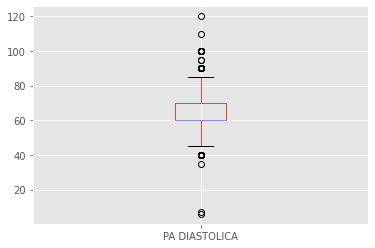

In [219]:
df.boxplot(column = 'PA SISTOLICA')
plt.show()
df.boxplot(column = 'PA DIASTOLICA')
plt.show()

Podemos inspecionar os diagramas de bigodes a fim de explorar a existência de outliers e a distribuição dos nossos dados. Vemos que existem outliers tão grandes como 180 no caso da PA sistólica ($\approx 5\times IQR + \text{média}$) e 120 no caso da PA diastólica ($\approx 6\times IQR + \text{média}$). Porém, se consultamos literatura acerca dos valores normais de pressão arterial veremos que só é considerada hipertensão se a PA SISTÓLICA estiver acima de 140, por isso podemos manter estes valores altos que vão até +- 180. Já para o limite inferior, é considerada baixa PA se se PA SISTÓLICA < 80 ou PA DIASTÓLICA < 60. Aqui vemos um caso de absurdamente baixa PA SISTÓLICA (10) e 3 casos de PA DIASTOLICA muito baixa (,6,6 e 7), que eliminaremos para evitar inconsistências.

In [226]:
df.drop(index = df.loc[df['PA SISTOLICA'] < 11.].index, inplace = True)
df.drop(index = df.loc[df['PA DIASTOLICA'] < 10.].index, inplace = True)

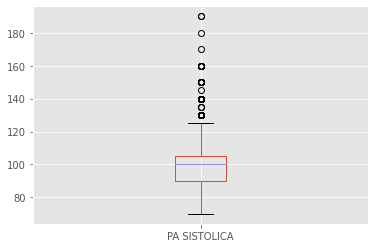

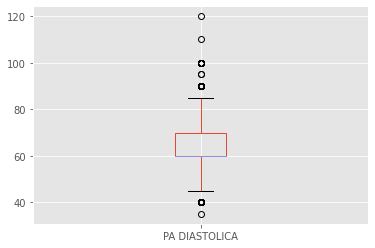

In [227]:
df.boxplot(column = 'PA SISTOLICA')
plt.show()
df.boxplot(column = 'PA DIASTOLICA')
plt.show()

## Normalização 

In [228]:
colunas_num = ['IDADE', 'PA SISTOLICA','PA DIASTOLICA','FC','IMC']

for coluna in colunas_num:
    print(coluna)
    df['normalized '+str(coluna)] = (df[coluna] - df[coluna].mean())/df[coluna].std()
df.head()

IDADE
PA SISTOLICA
PA DIASTOLICA
FC
IMC


,Altura,IMC,IDADE,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,SEXO,MOTIVO1,MOTIVO2,normalized IDADE,normalized PA SISTOLICA,normalized PA DIASTOLICA,normalized FC,normalized IMC
4,142,20.0,9.6,0,85.0,50.0,0,1,0,0,90.0,0,0,0,0,0.250276,-1.451839,-1.407656,0.388942,0.418451
5,112,21.0,4.4,0,100.0,60.0,0,1,1,0,100.0,1,0,1,1,-1.15291,-0.086316,-0.244837,0.915415,0.655865
7,117,20.0,5.89,0,110.0,65.0,1,1,0,0,80.0,1,1,0,2,-0.750846,0.824033,0.336573,-0.137530,0.418451
10,122,16.0,6.24,0,100.0,65.0,0,1,0,1,88.0,1,0,0,2,-0.6564,-0.086316,0.336573,0.283648,-0.531204
16,89,13.0,2.72,0,90.0,60.0,0,0,0,0,95.0,1,1,0,2,-1.60625,-0.996664,-0.244837,0.652179,-1.243446
